初始化

In [1]:
import os
os.environ['JOBLIB_TEMP_FOLDER'] = 'D:/jupyter notebook/temp_joblib'  
# 确保该路径存在且为ASCII，设置环境变量，指定joblib临时文件存储路径（避免并行计算时的路径问题）

In [2]:
#初始设置
import pandas as pd#数据处理
import numpy as np
import matplotlib.pyplot as plt#数据可视化
from dateutil.parser import parse#日期解析工具
from sklearn.model_selection import train_test_split#sklearn：机器学习工具（数据分割、编码、标准化）
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import toad#特征筛选工具

print('success')

success


数据加载与EDA

In [3]:
#定义训练集和测试集文件路径
train_path = './train.csv'
test_path = './testA.csv'

In [4]:
#读取数据
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [5]:
#读取CSV文件目标列到DataFrame
y = df_train.pop('isDefault')  #从训练集中分离目标变量 isDefault（是否违约）

In [6]:
#查看数据集
df_train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [7]:
#查看各字段类型
df_train.dtypes

id                      int64
loanAmnt              float64
term                    int64
interestRate          float64
installment           float64
grade                  object
subGrade               object
employmentTitle       float64
employmentLength       object
homeOwnership           int64
annualIncome          float64
verificationStatus      int64
issueDate              object
purpose                 int64
postCode              float64
regionCode              int64
dti                   float64
delinquency_2years    float64
ficoRangeLow          float64
ficoRangeHigh         float64
openAcc               float64
pubRec                float64
pubRecBankruptcies    float64
revolBal              float64
revolUtil             float64
totalAcc              float64
initialListStatus       int64
applicationType         int64
earliesCreditLine      object
title                 float64
policyCode            float64
n0                    float64
n1                    float64
n2        

In [8]:
#筛选文本类型字段其为对象类型（如 grade, subGrade）
objectcolumns = [col for col in df_train.columns if (df_train[col].dtypes == 'O')]#在Pandas中，'O'代表的是object（文本）类型
objectcolumns 

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [12]:
#查看数据缺失情况
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                    40270
n4                  

数据清洗

In [13]:
x = df_train.copy().set_index('id')
x_test = df_test.copy().set_index('id')
#创建特征数据集副本并设置'id'列为索引

文本类型字段的处理

In [14]:
 x.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,110000.0,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,46000.0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,74000.0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,118000.0,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,29000.0,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


'grade'

In [15]:
labelencoder = LabelEncoder()#创建LabelEncoder对象，用于将文本标签转换为数值

In [16]:
#对 grade 和 subGrade 进行标签编码（如"A"->0, "B"->1
x['grade'] = labelencoder.fit_transform(x['grade'])#训练集上拟合编码器并转换，先学习类别映射关系（如A→0, B→1），然后转换数据
x_test['grade'] = labelencoder.transform(x_test['grade']) 

In [18]:
x.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,4,E2,192025,2 years,2,110000.0,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,18000.0,5,18.49,461.90,3,D2,104733,5 years,0,46000.0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,3,D3,189509,8 years,0,74000.0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,11000.0,3,7.26,340.96,0,A4,249631,10+ years,1,118000.0,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,3000.0,3,12.99,101.07,2,C2,256267,NaN,1,29000.0,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


'subGrade'

In [19]:
x['subGrade'] = x['subGrade'].apply(lambda x: x[-1]).astype(int) + x['grade'] * 10
x_test['subGrade'] = x_test['subGrade'].apply(lambda x: x[-1]).astype(int)  + x_test['grade'] * 10

In [20]:
x.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,4,42,192025,2 years,2,110000.0,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,18000.0,5,18.49,461.90,3,32,104733,5 years,0,46000.0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,3,33,189509,8 years,0,74000.0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,11000.0,3,7.26,340.96,0,4,249631,10+ years,1,118000.0,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,3000.0,3,12.99,101.07,2,22,256267,NaN,1,29000.0,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


'employmentLength'

In [9]:
#查看'employmentLength'是否仅包含'year'，以确定是否可以直接保留数字
el = df_train[~df_train['employmentLength'].isnull()]['employmentLength']
#检查employmentLength列的每个值是否为NaN（缺失值），返回一个布尔Series：True表示缺失，False表示非缺失
#~是逻辑非运算符（取反），将结果反转：True变为非缺失，False变为缺失
#使用布尔索引筛选出employmentLength非缺失的所有行，返回一个DataFrame子集
#从筛选后的DataFrame中提取employmentLength列，赋值给变量el（此时el是非缺失值）
(~el.str.contains('year')).sum()

0

In [10]:
print(el[el.str.contains('<')])
print(el[(~el.str.contains('<')) & (el.str.contains('1 '))])

17        < 1 year
21        < 1 year
29        < 1 year
59        < 1 year
63        < 1 year
            ...   
799944    < 1 year
799947    < 1 year
799955    < 1 year
799967    < 1 year
799982    < 1 year
Name: employmentLength, Length: 64237, dtype: object
7         1 year
22        1 year
25        1 year
51        1 year
75        1 year
           ...  
799930    1 year
799963    1 year
799968    1 year
799970    1 year
799987    1 year
Name: employmentLength, Length: 52489, dtype: object


In [11]:
print(el[el.str.contains('\+')])
print(el[(el.str.contains('10')) & (~el.str.contains('\+'))])

<>:1: SyntaxWarning: invalid escape sequence '\+'
<>:2: SyntaxWarning: invalid escape sequence '\+'
<>:1: SyntaxWarning: invalid escape sequence '\+'
<>:2: SyntaxWarning: invalid escape sequence '\+'
C:\Users\韩\AppData\Local\Temp\ipykernel_23912\2188708863.py:1: SyntaxWarning: invalid escape sequence '\+'
  print(el[el.str.contains('\+')])
C:\Users\韩\AppData\Local\Temp\ipykernel_23912\2188708863.py:2: SyntaxWarning: invalid escape sequence '\+'
  print(el[(el.str.contains('10')) & (~el.str.contains('\+'))])


3         10+ years
10        10+ years
13        10+ years
18        10+ years
24        10+ years
            ...    
799985    10+ years
799990    10+ years
799996    10+ years
799997    10+ years
799998    10+ years
Name: employmentLength, Length: 262753, dtype: object
Series([], Name: employmentLength, dtype: object)


In [21]:
def getel(x): #getel = get employmentLength
    if type(x) == float: #NaN的类型不为None，而是float
        pass
    elif '<' in x:
        return 0.5
    elif '+' in x:
        return 10
    else:
        return int(x[0])

In [22]:
x['employmentLength'] = x['employmentLength'].apply(getel)
x_test['employmentLength'] = x_test['employmentLength'].apply(getel)# employmentLength 文本（如"5 years"）转换为数值

In [17]:
#高维类别特征需要进行转换
for col in ['employmentTitle', 'title']:
    labelencoder.fit(list(x[col].astype(str).values) + list(x_test[col].astype(str).values))#将训练集和测试集的值合并为一个列表，astype(str)确保处理字符串类型
    x[col] = labelencoder.transform(x[col].astype(str))#转换训练集
    x_test[col] = labelencoder.transform(x_test[col].astype(str))
    #对高维类别特征（职位名称）进行编码，避免维度爆炸

In [23]:
x.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,4,42,192025,2.0,2,110000.0,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,18000.0,5,18.49,461.90,3,32,104733,5.0,0,46000.0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,3,33,189509,8.0,0,74000.0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,11000.0,3,7.26,340.96,0,4,249631,10.0,1,118000.0,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,3000.0,3,12.99,101.07,2,22,256267,NaN,1,29000.0,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


'issueDate

In [24]:
#将日期字段拆分为年、月、日三列，便于模型学习时间模式
x['issueDate'] = x['issueDate'].apply(parse)
x_test['issueDate'] = x_test['issueDate'].apply(parse)

In [25]:
x['issueDate_Year'] = x['issueDate'].apply(lambda x: x.year)
x['issueDate_Month'] = x['issueDate'].apply(lambda x: x.month)
x['issueDate_Day'] = x['issueDate'].apply(lambda x: x.day)

x = x.drop(columns='issueDate')

In [26]:
# 同样处理测试集
x_test['issueDate_Year'] = x_test['issueDate'].apply(lambda x: x.year)
x_test['issueDate_Month'] = x_test['issueDate'].apply(lambda x: x.month)
x_test['issueDate_Day'] = x_test['issueDate'].apply(lambda x: x.day)

x_test = x_test.drop(columns='issueDate')

In [27]:
x.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n8,n9,n10,n11,n12,n13,n14,issueDate_Year,issueDate_Month,issueDate_Day
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,4,42,192025,2.0,2,110000.0,...,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2014,7,1
1,18000.0,5,18.49,461.90,3,32,104733,5.0,0,46000.0,...,NaN,NaN,13.0,NaN,NaN,NaN,NaN,2012,8,1
2,12000.0,5,16.99,298.17,3,33,189509,8.0,0,74000.0,...,5.0,3.0,11.0,0.0,0.0,0.0,4.0,2015,10,1
3,11000.0,3,7.26,340.96,0,4,249631,10.0,1,118000.0,...,21.0,6.0,9.0,0.0,0.0,0.0,1.0,2015,8,1
4,3000.0,3,12.99,101.07,2,22,256267,NaN,1,29000.0,...,15.0,7.0,12.0,0.0,0.0,0.0,4.0,2016,3,1


'earliesCreditLine'

In [28]:
x['earliesCreditLine'] = x['earliesCreditLine'].apply(parse)
x_test['earliesCreditLine'] = x_test['earliesCreditLine'].apply(parse)

In [29]:
x['earliesCreditLine_Year'] = x['earliesCreditLine'].apply(lambda x: x.year)
x['earliesCreditLine_Month'] = x['earliesCreditLine'].apply(lambda x: x.month)

x = x.drop(columns='earliesCreditLine')

In [30]:
x_test['earliesCreditLine_Year'] = x_test['earliesCreditLine'].apply(lambda x: x.year)
x_test['earliesCreditLine_Month'] = x_test['earliesCreditLine'].apply(lambda x: x.month)

x_test = x_test.drop(columns='earliesCreditLine')

In [31]:
x.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n10,n11,n12,n13,n14,issueDate_Year,issueDate_Month,issueDate_Day,earliesCreditLine_Year,earliesCreditLine_Month
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,4,42,192025,2.0,2,110000.0,...,7.0,0.0,0.0,0.0,2.0,2014,7,1,2001,8
1,18000.0,5,18.49,461.90,3,32,104733,5.0,0,46000.0,...,13.0,NaN,NaN,NaN,NaN,2012,8,1,2002,5
2,12000.0,5,16.99,298.17,3,33,189509,8.0,0,74000.0,...,11.0,0.0,0.0,0.0,4.0,2015,10,1,2006,5
3,11000.0,3,7.26,340.96,0,4,249631,10.0,1,118000.0,...,9.0,0.0,0.0,0.0,1.0,2015,8,1,1999,5
4,3000.0,3,12.99,101.07,2,22,256267,NaN,1,29000.0,...,12.0,0.0,0.0,0.0,4.0,2016,3,1,1977,8


In [32]:
#查看字段类型是否已全部转换为数值类型
x.dtypes

loanAmnt                   float64
term                         int64
interestRate               float64
installment                float64
grade                        int32
subGrade                     int32
employmentTitle              int32
employmentLength           float64
homeOwnership                int64
annualIncome               float64
verificationStatus           int64
purpose                      int64
postCode                   float64
regionCode                   int64
dti                        float64
delinquency_2years         float64
ficoRangeLow               float64
ficoRangeHigh              float64
openAcc                    float64
pubRec                     float64
pubRecBankruptcies         float64
revolBal                   float64
revolUtil                  float64
totalAcc                   float64
initialListStatus            int64
applicationType              int64
title                        int32
policyCode                 float64
n0                  

缺失值处理

In [33]:
for col in x.columns:
    if x[col].dtype == 'int64':
     value = x[col].mode()[0]
    else:
     value = x[col].mean()
    x[col].fillna(value=value, inplace=True)
    x_test[col].fillna(value=value, inplace=True)

C:\Users\韩\AppData\Local\Temp\ipykernel_23912\3180223801.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x[col].fillna(value=value, inplace=True)
C:\Users\韩\AppData\Local\Temp\ipykernel_23912\3180223801.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

In [34]:
print(x.isnull().sum().sum())
print(x_test.isnull().sum().sum())

0
0


构建新特征

In [35]:
#贷款发放与信用额度开立的年份差
x['datediff'] = x['issueDate_Year'] - x['earliesCreditLine_Year'] 
x_test['datediff'] = x_test['issueDate_Year'] - x_test['earliesCreditLine_Year'] #同理处理测试集

#计算债务收入比
x['dti_cal'] = (x['loanAmnt'] / (x['annualIncome'])).replace(np.inf, np.nan)
x_test['dti_cal'] = (x_test['loanAmnt'] / (x_test['annualIncome'])).replace(np.inf, np.nan)

#当前未结清的信用账户数占总信用账户数的比例（openAcc_totalAcc_ratio)
x['openAcc_totalAcc_ratio'] = x['openAcc'].div(x['totalAcc'])
x_test['openAcc_totalAcc_ratio'] = x_test['openAcc'] / x_test['totalAcc']

#总收入
x['totalincome'] = x['annualIncome'] * x['employmentLength']
x_test['totalincome'] = x_test['annualIncome'] * x_test['employmentLength']

#贷款结束年份
x['end_year'] = x['issueDate_Year'] + x['term']
x_test['end_year'] = x_test['issueDate_Year'] + x_test['term']

In [36]:
x.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,issueDate_Year,issueDate_Month,issueDate_Day,earliesCreditLine_Year,earliesCreditLine_Month,datediff,dti_cal,openAcc_totalAcc_ratio,totalincome,end_year
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,4,42,192025,2.0,2,110000.0,...,2014,7,1,2001,8,13,0.318182,0.259259,220000.0,2019
1,18000.0,5,18.49,461.90,3,32,104733,5.0,0,46000.0,...,2012,8,1,2002,5,10,0.391304,0.722222,230000.0,2017
2,12000.0,5,16.99,298.17,3,33,189509,8.0,0,74000.0,...,2015,10,1,2006,5,9,0.162162,0.407407,592000.0,2020
3,11000.0,3,7.26,340.96,0,4,249631,10.0,1,118000.0,...,2015,8,1,1999,5,16,0.093220,0.321429,1180000.0,2018
4,3000.0,3,12.99,101.07,2,22,256267,-1.0,1,29000.0,...,2016,3,1,1977,8,39,0.103448,0.444444,-29000.0,2019


筛选特征¶

In [37]:
#通过IV（信息量）和PSI（稳定性）筛选重要特征，避免过拟合

In [38]:
iv_info = toad.quality(x, y, iv_only=True)# 计算IV值（特征重要性）

In [39]:
iv_info

,iv,gini,entropy,unique
subGrade,0.485107,NaN,NaN,35.0
interestRate,0.463530,NaN,NaN,641.0
grade,0.463477,NaN,NaN,7.0
term,0.172635,NaN,NaN,2.0
end_year,0.126588,NaN,NaN,14.0
ficoRangeHigh,0.125253,NaN,NaN,39.0
ficoRangeLow,0.125253,NaN,NaN,39.0
dti_cal,0.121284,NaN,NaN,109707.0
dti,0.072868,NaN,NaN,6321.0
verificationStatus,0.054519,NaN,NaN,3.0


In [40]:
psi_info = toad.metrics.PSI(x, x_test).round(3).sort_values(ascending=False) # 计算PSI值（特征稳定性）

In [41]:
psi_info

revolBal                   0.233
installment                0.192
employmentTitle            0.151
dti_cal                    0.098
totalincome                0.042
annualIncome               0.041
dti                        0.028
title                      0.019
loanAmnt                   0.009
revolUtil                  0.008
openAcc_totalAcc_ratio     0.007
postCode                   0.005
interestRate               0.004
n6                         0.001
totalAcc                   0.001
n7                         0.000
n8                         0.000
n9                         0.000
n10                        0.000
n11                        0.000
n12                        0.000
n13                        0.000
homeOwnership              0.000
n14                        0.000
n5                         0.000
issueDate_Month            0.000
issueDate_Day              0.000
earliesCreditLine_Year     0.000
earliesCreditLine_Month    0.000
datediff                   0.000
grade     

In [42]:
#提取高相关特征
low_corr_feature = [col for col in iv_info[iv_info['iv'] <= 0.004].index] # 筛选特征：剔除低IV（<0.004）或高PSI（>0.1）的特征
high_psi_feature = [col for col in psi_info[psi_info > 0.1].index]

feature = [col for col in x.columns if col not in (low_corr_feature + high_psi_feature)]
feature

['loanAmnt',
 'term',
 'interestRate',
 'grade',
 'subGrade',
 'employmentLength',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolUtil',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n12',
 'n13',
 'n14',
 'issueDate_Year',
 'earliesCreditLine_Year',
 'datediff',
 'dti_cal',
 'openAcc_totalAcc_ratio',
 'totalincome',
 'end_year']

In [43]:
# 保留筛选后的特征
x = x[feature]
x_test = x_test[feature]

归一化

In [44]:
# 数据标准化（Z-score标准化）将数据标准化为均值为0、方差为1，加速模型收敛。
scaler = StandardScaler()

In [45]:
x_std = pd.DataFrame(scaler.fit_transform(x), index=x.index, columns=x.columns)
x_test_std = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

catboost模型

Fold 1:


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 1 最终验证AUC: 0.73460
Fold 2:


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 2 最终验证AUC: 0.73483
Fold 3:


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 3 最终验证AUC: 0.73400
Fold 4:


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 4 最终验证AUC: 0.73225
Fold 5:


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fold 5 最终验证AUC: 0.73478

******************************
平均交叉验证AUC: 0.73409


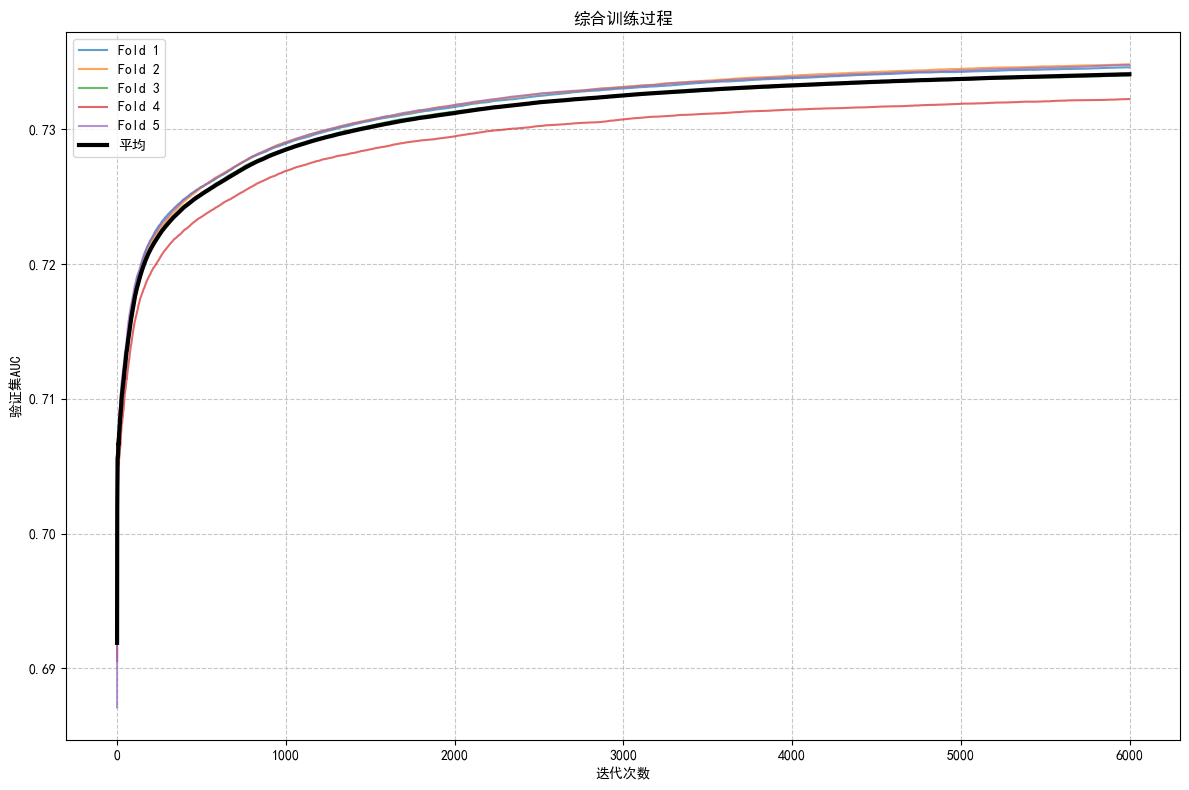

In [46]:
import catboost
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# 设置中文字体支持
plt.rcParams['font.sans-serif'], plt.rcParams['axes.unicode_minus'] = ['SimHei'], False

# 初始化存储容器
# 5折交叉训练CatBoost
nsplits = 5
cv_score, y_test_preds, all_eval_metrics = 0, [], []

for i in range(nsplits):
    print(f'Fold {i+1}:')
    # 数据划分
    x_train, x_cv, y_train, y_cv = train_test_split(x, y, train_size=0.9, random_state=i+1)
    
    # 创建并训练模型
    model = CatBoostClassifier(
        iterations=6000, eval_metric='AUC', learning_rate=0.02, depth=5,
        l2_leaf_reg=5, loss_function='CrossEntropy', early_stopping_rounds=250
    ) # 损失函数（交叉熵，用于分类）
    model.fit(x_train, y_train, eval_set=(x_cv, y_cv), plot=True, verbose=False)
    
    # 绘制单折训练图
    plt.figure(figsize=(10, 6))
    plt.plot(eval_results['learn'].get(train_key, []), label='训练集AUC', alpha=0.7)
    plt.plot(val_metrics, label='验证集AUC', alpha=0.7)
    plt.title(f'Fold {i+1} 训练过程'), plt.xlabel('迭代次数'), plt.ylabel('AUC')
    plt.grid(True, linestyle='--', alpha=0.5), plt.legend(), plt.tight_layout()
    plt.savefig(f'训练过程{i+1}.png'), plt.close()

# 输出平均AUC
print(f"\n{'*'*30}\n平均交叉验证AUC: {cv_score/nsplits:.5f}")

# 绘制综合训练过程图
if all_eval_metrics:
    plt.figure(figsize=(12, 8))
    max_len = max(len(m) for m in all_eval_metrics)
    avg_auc = [np.nanmean([m[i] for m in all_eval_metrics if i < len(m)]) for i in range(max_len)]
    
    for i, metrics in enumerate(all_eval_metrics):
        plt.plot(metrics, label=f'Fold {i+1}', alpha=0.7)
    plt.plot(avg_auc, 'k-', linewidth=3, label='平均')
    
    plt.title('综合训练过程'), plt.xlabel('迭代次数'), plt.ylabel('验证集AUC')
    plt.grid(True, linestyle='--', alpha=0.7), plt.legend(), plt.tight_layout()
    plt.savefig('综合训练过程图.png'), plt.show()

In [47]:
submission = pd.DataFrame(x_test.index)
submission['isDefault'] = sum(y_test_preds) / nsplits
submission

,id,isDefault
0,800000,0.073008
1,800001,0.334279
2,800002,0.546832
3,800003,0.329211
4,800004,0.412754
...,...,...
199995,999995,0.145267
199996,999996,0.038701
199997,999997,0.154452
199998,999998,0.215464
